In [1]:
using OrdinaryDiffEq
using LinearAlgebra
using PlotlyJS
using FFTW

# Numerical solution

Comparison of the full numerical solution and the RWA. Here the RWA is applied on the drive. The coupling is $\sigma_x = \sigma_+ + \sigma_-$. Going into the Heisenberg picture, we see that $\sigma_+(t) = e^{-i H_0 t} \sigma_+ e^{i H_0 t} = e^{-i\omega_d t} \sigma_+$ and similarly for $\sigma_-$. Therefore, we can expand out the sinusoidal drive and keep only terms that do not rotate. 

Nota bene: We assume a closed system, ignoring single-photon loss. 

Nota bene bene: In the present context, we let $\varepsilon_d(t)$ be a constant. We can relax this later. 

In [89]:
const ϵ = 1.
const ωd = 0.9
const δ = ϵ - ωd # IF DELTA IS NONZERO I HAVE TO ADD A PHASE FACTOR TO THE TIME-EVOLUTION MATRIX
const εd = 0.15

const H3 = diagm(ComplexF64[0,ϵ,3ϵ])

function g(t)
    εd*sin(ωd * t)
end

function exp_plus(t)
    εd/(2im)*exp(1im * ωd * t)
end

const M2 = ComplexF64[0 1 0; 1 0 1; 0 1. 0]

const M2p = ComplexF64[0 1 0; 0 0 1; 0 0. 0]
const M2m = ComplexF64[0 0 0; 1. 0 0; 0 1. 0];

In [29]:
function f(du, u, p, t)
    # du .= -im * H3 * u - -im * g(t) * M2 * u
    mul!(du, H3, u, -im, false)
    mul!(du, M2, u, -im * g(t), true)
end

function f_rwa(du, u, p, t)
    # du .= -im * H3 * u - -im * g(t) * M2 * u
    mul!(du, H3, u, -im, false)
    mul!(du, M2m, u, -im * conj(exp_plus(t)), true)
    mul!(du, M2p, u, -im * exp_plus(t), true)
end

u0 = ComplexF64[1., 0, 0]

tspan = (0., 10 * π/εd)

prob = ODEProblem(f, u0, tspan, abstol=1e-7, reltol=1e-5)
prob_rwa = ODEProblem(f_rwa, u0, tspan, abstol=1e-7, reltol=1e-5)

sol = solve(prob, Tsit5())
sol_rwa = solve(prob_rwa, Tsit5());


In [30]:
ψ = sol.u
c0 = getindex.(sol.u, 1);

ψ_rwa = sol_rwa.u
c0_rwa = getindex.(sol_rwa.u, 1);

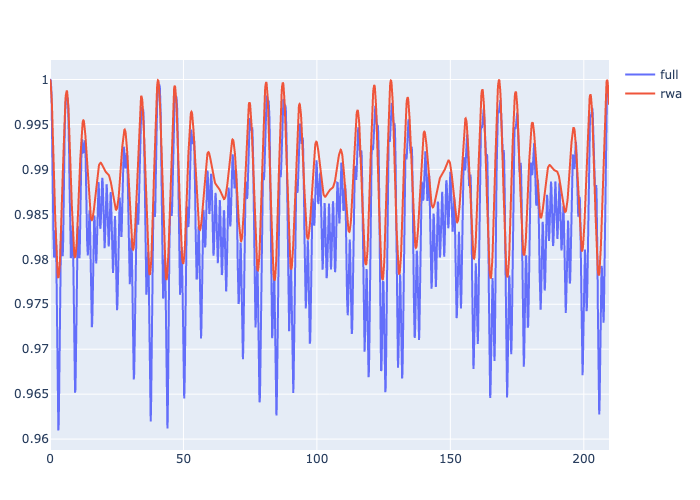

In [31]:
plot_full = scatter(x = sol.t, y = abs2.(c0), mode = "lines", name = "full")
plot_rwa = scatter(x = sol_rwa.t, y = abs2.(c0_rwa), mode = "lines", name = "rwa")

# imag_plot = scatter(x = sol.t, y = imag(c0), mode = "lines", name = "imag")

plot([plot_full, plot_rwa])

When $\omega_d = 2\epsilon$, the $1\to 2$ transition is probed. Starting a state initially in $c_0 = 1$ it will remain this way with very small variations. But, we can see the counter-rotating terms very clearly. 

## Expectation values and spectrum

do later

# Analytical solution

We now implement our own analytical solution. Starting from the time-dependent SE, and making some ansatze involving the various coefficients, we arrive at the exact equation
\begin{equation}
    \sum_n (\dot{c_{m,n}} - i n \omega_d c_{m,n}) e^{-i n \omega_d t} = -i \varepsilon_d \sin{\omega_d t }\sum_{k,n} z_{mk} e^{-i E_{km} t} e^{-i n \omega_d t} c_{k,n}.
    \end{equation}

The first assumption is that when looking at a term with a fixed $n$, only those rotating at the frequency $n \omega_d$ will be important. <span style="color:red">This could be a faulty assumption -- revisit.</span> Nevertheless we continue, and find 
\begin{align}
    \dot{c_0}(t) &= -i \varepsilon_d \sin{\omega_d t} \left[x_{00} c_0 (t) + x_{01} e^{-i \omega_d t} c_1(t) + x_{02} e^{-3i \omega_d t} c_2(t)  \right] \\
    \dot{c_1}(t) &= -i \varepsilon_d \sin{\omega_d t} \left[x_{10} e^{i \omega_d t} c_0 (t) + x_{11} c_1(t) + x_{12} e^{-2i \omega_d t} c_2(t)  \right] \\
    \dot{c_2}(t) &= -i \varepsilon_d \sin{\omega_d t} \left[x_{20} e^{3i \omega_d t} c_0 (t) + x_{21} e^{2i \omega_d t} c_1(t) + x_{22} c_2(t)  \right].
\end{align}
These are actually the exact equations of the schrodinger equation, so we will basically be doing the same thing as above. It starts to become different, however, when there is a slight difference between $\omega_d$ and $\epsilon$. In this case we can not just cleanly pick out the terms we want. But actually it is quite similar, and so nothing really changes aside from the fact that there is an additional phase tacked on to every term where there should be a $e^{i E t}$.

We can move away from RWA by taking only the $e^{\pm i \omega_d t}$ terms, then also $e^{\pm 2 i \omega_d t}$ etc etc.

First, we redo the full and RWA simulations in this model, since our $c_i$'s are defined a bit differently I think (up to a phase factor of the energy). We are therefore more or less in a rotating frame $U(t) = e^{-i H_0 t}$.

In [90]:
# re-write the full system of equations in the rotating frame
# expand the sines into exponentials
function f_full(du, u, p, t)
    du[1] = -εd/2 * ((1 - exp(-2im * ωd * t)) * u[2])
    du[2] = -εd/2 * ((exp(2im * ωd * t) - 1) * u[1] + (exp(-1im * ωd * t) - exp(-3im * ωd * t)) * u[3])
    du[3] = -εd/2 * ((exp(3im * ωd * t) - exp(1im * ωd * t)) * u[2])
end

function f_rwa_analytic(du, u, p, t)
    du[1] = -εd/2 * u[2]
    du[2] = εd/2 * u[1]
    du[3] = 0
end;

function f_1_analytic(du, u, p, t)
    du[1] = -εd/2 * u[2]
    du[2] = -εd/2 * (- 1 * u[1] + exp(-1im * ωd * t) * u[3])
    du[3] = εd/2 * exp(1im * ωd * t) * u[2]
end

function f_2_analytic(du, u, p, t)
    du[1] = -εd/2 * ((1 - exp(-2im * ωd * t)) * u[2])
    du[2] = -εd/2 * ((exp(2im * ωd * t) - 1) * u[1] + exp(-1im * ωd * t) * u[3])
    du[3] = εd/2 * exp(1im * ωd * t) * u[2]
end

f_2_analytic (generic function with 1 method)

## Time-evolution of the coefficients

In [91]:
u0_analytic = ComplexF64[1., 0, 0]

tspan = (0., 4 * π/εd)

prob_analytic = ODEProblem(f_full, u0_analytic, tspan, abstol=1e-7, reltol=1e-5)
prob_rwa_analytic = ODEProblem(f_rwa_analytic, u0_analytic, tspan, abstol=1e-7, reltol=1e-5)

sol = solve(prob_analytic, Tsit5())
sol_rwa = solve(prob_rwa_analytic, Tsit5());

In [92]:
ψ = sol.u
c0 = getindex.(sol.u, 1);

ψ_rwa = sol_rwa.u
c0_rwa = getindex.(sol_rwa.u, 1);

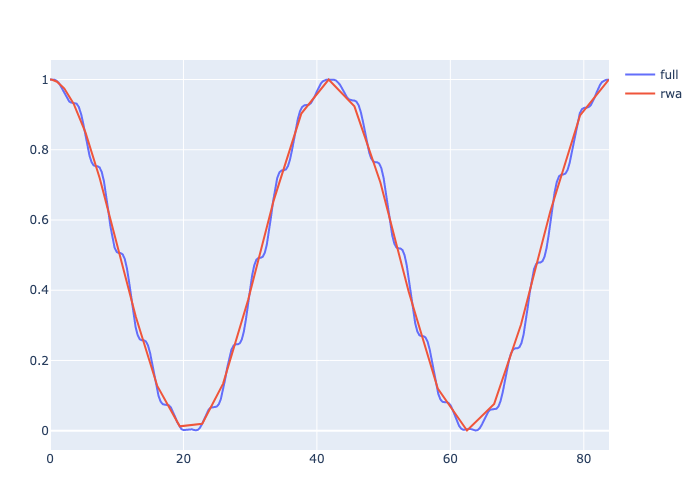

In [93]:
plot_full = scatter(x = sol.t, y = abs2.(c0), mode = "lines", name = "full")
plot_rwa = scatter(x = sol_rwa.t, y = abs2.(c0_rwa), mode = "lines", name = "rwa")

plot([plot_full, plot_rwa])

As expected, the RWA misses important oscillating behaviour. The frequency is $\varepsilon_d / 2$. Interestingly, there is no phase shift.

Now, we will look at the terms away from the RWA.

In [94]:
prob_analytic_1 = ODEProblem(f_1_analytic, u0_analytic, tspan, abstol=1e-7, reltol=1e-5)

sol_1 = solve(prob_analytic_1, Tsit5());

ψ1 = sol_1.u
c0_1 = getindex.(ψ1, 1);

prob_analytic_2 = ODEProblem(f_2_analytic, u0_analytic, tspan, abstol=1e-7, reltol=1e-5)

sol_2 = solve(prob_analytic_2, Tsit5());

ψ2 = sol_2.u
c0_2 = getindex.(ψ2, 1);

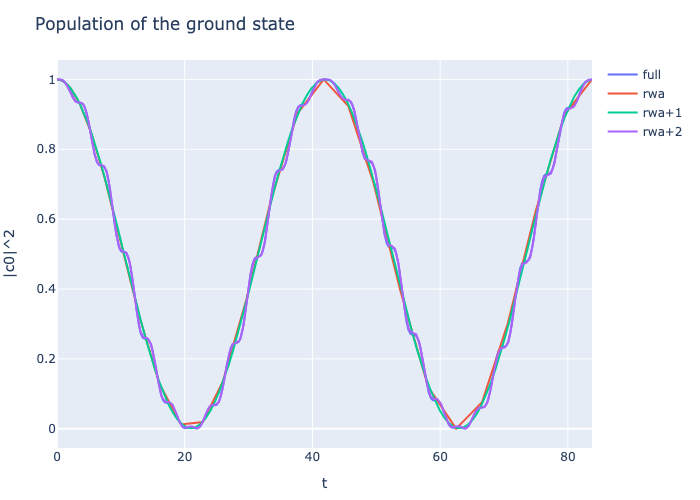

In [95]:
plot_full = scatter(x = sol.t, y = abs2.(c0), mode = "lines", name = "full")
plot_rwa = scatter(x = sol_rwa.t, y = abs2.(c0_rwa), mode = "lines", name = "rwa")
plot_1 = scatter(x = sol_1.t, y = abs2.(c0_1), mode = "lines", name = "rwa+1")
plot_2 = scatter(x = sol_2.t, y = abs2.(c0_2), mode = "lines", name = "rwa+2")

layout = Layout(yaxis_title="|c0|^2", xaxis_title="t", title="Population of the ground state")

plot([plot_full, plot_rwa, plot_1, plot_2], layout)

Keeping in terms up to $e^{\pm2i\omega_d t}$ seems to work best. Because any higher order terms are linked to the $0\to 2$ transition which is not being probed by the present drive. In fact, the RWA+1 approximation does not have any of the full model characteristics. 

To see this we can quickly look at the spectrum in frequency space:

In [82]:
S_full = fftshift(fft(abs2.(c0)))
# S_rwa = fftshift(fft(c0_rwa))
# S_1 = fftshift(fft(c0_1))
# S_2 = fftshift(fft(c0_2));

freq_full = fftshift(fftfreq(length(S_full), 1/length(S_full)))
# freq_rwa = fftshift(fftfreq(length(S_rwa), 1/length(S_rwa)))
# freq_1 = fftshift(fftfreq(length(S_1), 1/length(S_1)))
# freq_2 = fftshift(fftfreq(length(S_2), 1/length(S_2)));

-0.0028735632183908046:3.302946228035408e-5:0.0028405337561104504

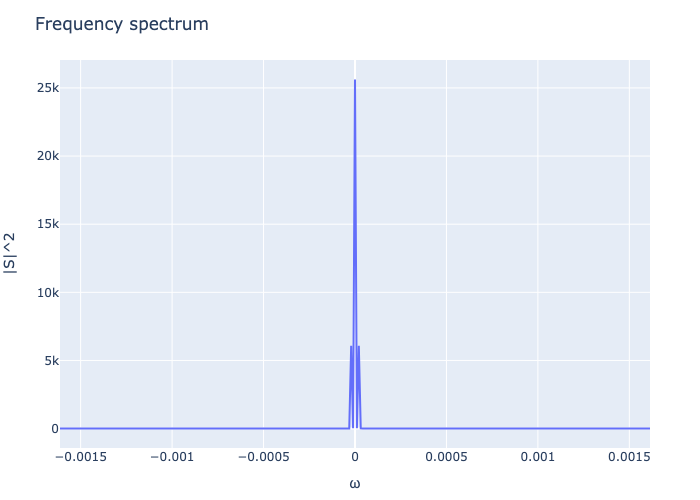

In [59]:
# plot them
plot_full = scatter(x = freq_full, y = abs2.(S_full), mode = "lines", name = "full")
plot_rwa = scatter(x = freq_rwa, y = abs2.(S_rwa), mode = "lines", name = "rwa")
plot_1 = scatter(x = freq_1, y = abs2.(S_1), mode = "lines", name = "rwa+1")
plot_2 = scatter(x = freq_2, y = abs2.(S_2), mode = "lines", name = "rwa+2")

layout = Layout(yaxis_title="|S|^2", xaxis_title="ω", title="Frequency spectrum")

plot([plot_full], layout)


This "hand-made" model doesn't work if we change the frequency to $\omega_d = 2\epsilon$, for example, in order to probe the $2 \to 1$ transition. We would have to re-derive the full equations of motion

## Benchmark the different approximations

In [60]:
using BenchmarkTools

In [36]:
@benchmark solve(prob_analytic, Tsit5())

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  202.792 μs …  3.135 ms  ┊ GC (min … max): 0.00% … 92.80%
 Time  (median):     212.041 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   220.214 μs ± 45.884 μs  ┊ GC (mean ± σ):  1.36% ±  5.30%

      ▄█▇▃                                                      
  ▁▂▃▇████▇▄▄▃▃▃▄▄▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  203 μs          Histogram: frequency by time          274 μs <

 Memory estimate: 330.41 KiB, allocs estimate: 2828.

In [37]:
@benchmark solve(prob_analytic_2, Tsit5())

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  107.167 μs …  2.878 ms  ┊ GC (min … max): 0.00% … 95.46%
 Time  (median):     111.312 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   116.054 μs ± 37.157 μs  ┊ GC (mean ± σ):  1.59% ±  5.03%

      ▇█▆                                                       
  ▁▂▃█████▅▄▃▃▂▂▂▂▃▆▇▇▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  107 μs          Histogram: frequency by time          141 μs <

 Memory estimate: 215.23 KiB, allocs estimate: 1775.

In [38]:
@benchmark solve(prob_analytic_1, Tsit5())

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  61.084 μs …  3.769 ms  ┊ GC (min … max): 0.00% … 97.73%
 Time  (median):     64.750 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   67.934 μs ± 42.510 μs  ┊ GC (mean ± σ):  2.11% ±  4.53%

      ▃▆█▅         ▁                                           
  ▁▁▃▅█████▅▂▂▂▃▄▆▇███▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  61.1 μs         Histogram: frequency by time        83.3 μs <

 Memory estimate: 142.86 KiB, allocs estimate: 1268.

In [39]:
@benchmark solve(prob_rwa_analytic, Tsit5())

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   9.875 μs …  57.941 ms  ┊ GC (min … max):  0.00% … 99.94%
 Time  (median):     11.583 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   17.693 μs ± 579.319 μs  ┊ GC (mean ± σ):  33.00% ±  1.38%

            █▆█▁▁                                               
  ▂▂▄▄▇▇█▆▇██████▆▇▅▅▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂ ▃
  9.88 μs         Histogram: frequency by time         18.6 μs <

 Memory estimate: 32.19 KiB, allocs estimate: 293.

## Small detuning

All of this was done at resonance, $\omega_d = \epsilon$. We now allow for some detuning such that the equations of motion now carry an additional $e^{\pm i \delta t}$:

\begin{align}
    \dot{c_0}(t) &= -i \varepsilon_d \sin{\omega_d t} \left[x_{00} c_0 (t) + x_{01} e^{-i \omega_d t} c_1(t) + x_{02} e^{-3i \omega_d t} c_2(t)  \right] \\
    \dot{c_1}(t) &= -i \varepsilon_d \sin{\omega_d t} \left[x_{10} e^{i \omega_d t} c_0 (t) + x_{11} c_1(t) + x_{12} e^{-2i \omega_d t} c_2(t)  \right] \\
    \dot{c_2}(t) &= -i \varepsilon_d \sin{\omega_d t} \left[x_{20} e^{3i \omega_d t} c_0 (t) + x_{21} e^{2i \omega_d t} c_1(t) + x_{22} c_2(t)  \right].
\end{align}


i haven't changed these equations yet, I'm too lazy.

In [96]:
const δ = ϵ - ωd
const Δ = ϵ + ωd

function f_full_detuned(du, u, p, t)
    du[1] = -εd/2 * (exp(-1im*δ*t) - exp(-1im*Δ*t)) * u[2]
    du[2] = -εd/2 * ((exp(1im*Δ*t) - exp(1im*δ*t)) * u[1] + (exp(-1im * (2ϵ - ωd) * t) - exp(-1im * (2ϵ + ωd) * t)) * u[3])
    du[3] = -εd/2 * ((exp(-1im * (-2ϵ - ωd) * t) - exp(-1im * (-2ϵ + ωd) * t)) * u[2])
end;

In [97]:
u0_detuned = ComplexF64[1., 0, 0]

tspan = (0., 4 * π/εd)

prob_detuned = ODEProblem(f_full_detuned, u0_detuned, tspan, abstol=1e-7, reltol=1e-5)

sol = solve(prob_detuned, Tsit5());

ψ = sol.u
c0 = getindex.(sol.u, 1);

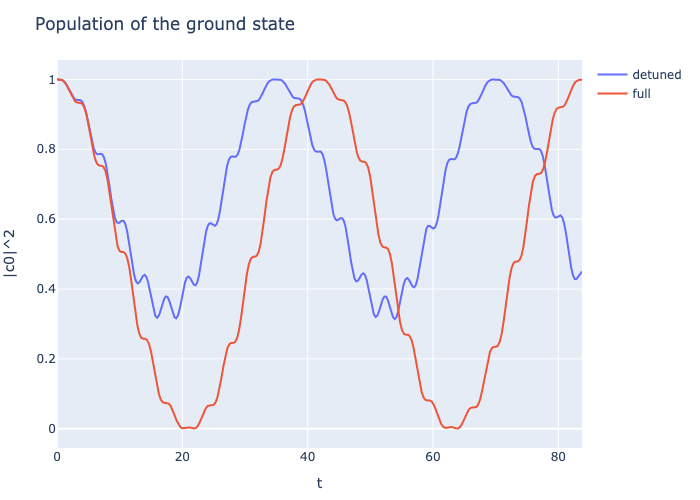

In [99]:
plot_detuned = scatter(x = sol.t, y = abs2.(c0), mode = "lines", name = "detuned")

layout = Layout(yaxis_title="|c0|^2", xaxis_title="t", title="Population of the ground state")

plot([plot_detuned, plot_full], layout)

As we can see, even a relatively small detuning $\delta = 0.1$ has a great impact on the difference of the plots.

## Systematic approximation 

When $\epsilon \neq \omega_d$, or when the equations of motion are bigger and more cumbersome, we would like to simplify the full EoM into only resonant parts, some off-resonant, etc... in a systematic way. This problem essentially boils down to this:
\begin{equation}
    \dot{c_m}(t) = -i\epsilon_d(t) \sum_k e^{-i E_{km} t} x_{mk} c_k(t) = -i \sum_k f(t,k,m) x_{mk} c_k(t)
\end{equation}
where $f(t,k,m) = \epsilon_d(t)e^{-i E_{km} t}$, and we must find the smallest magnitude $\omega$'s that constitute f(t). To do so, we Fourier transform it.

## Correlation function

Next we will compute some observables with our different levels of approximations.